## Import libraries

In [48]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [49]:
# HYPERPARAMETERS
SEQUENCE_SIZE = 3
dataset_path = "ParkingDataDataset.txt"
split_ratio = 0.7 # 70% training, 30% testing
batch_size = 32

# Regarding training loop
epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')
learning_rate = 0.001

## Load dataset

In [50]:
# read text file into pandas DataFrame
df = pd.read_csv(dataset_path, sep="\t")
df.head(10)

,DateTime,Car ID,Vehicle,VType,Day,ReqT,EntHr,EntMin,ExitHr,ExitMin,...,Tries,DFS,IdleVeh,tFree,z1Free,z2Free,z3Free,z4Free,dReq,Unnamed: 27
0,2022-01-01 08:25:00,936,Student,3,1,406,8,25,8,32,...,1,365,5,93,14,49,8,22,1,NaN
1,2022-01-01 08:25:00,937,Faculty,2,1,1333,8,25,8,47,...,1,354,6,93,14,49,8,22,1,NaN
2,2022-01-01 08:00:00,942,Staff,5,1,8883,8,0,8,0,...,2,672,17,0,0,0,0,0,1,NaN
3,2022-01-01 08:39:00,948,Visitor,1,1,1143,8,39,8,58,...,1,365,12,88,12,46,8,22,1,NaN
4,2022-01-01 08:00:00,983,Student,3,1,7432,8,0,8,0,...,2,672,15,0,0,0,0,0,2,NaN
5,2022-01-01 08:55:00,959,Faculty,2,1,731,8,55,9,8,...,1,354,17,74,3,41,8,22,2,NaN
6,2022-01-01 08:00:00,975,Faculty,2,1,4296,8,0,8,0,...,2,672,12,0,0,0,0,0,2,NaN
7,2022-01-01 09:21:00,977,Student,3,1,95,9,21,9,22,...,1,365,16,60,1,29,8,22,3,NaN
8,2022-01-01 09:16:00,984,Student,3,1,424,9,16,9,23,...,1,354,17,62,1,31,8,22,3,NaN
9,2022-01-01 08:00:00,992,Faculty,2,1,7713,8,0,8,0,...,2,672,14,0,0,0,0,0,6,NaN


In [51]:
df.columns

Index(['DateTime            ', 'Car ID', 'Vehicle', 'VType', 'Day', 'ReqT',
       'EntHr', 'EntMin', 'ExitHr', 'ExitMin', 'TDelay', 'IdleT', 'TBill',
       'Fine', 'PL No.', 'PLZone', 'nFree', 'nFill', 'Tries', 'DFS', 'IdleVeh',
       'tFree', 'z1Free', 'z2Free', 'z3Free', 'z4Free', 'dReq', 'Unnamed: 27'],
      dtype='object')

## Pre-process the dataset

In [52]:
# PREPROCESS THE MAIN DATASET TO GET CLEANED DATA
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df.head()


Index Column Created!


,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52


In [53]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()
ts.head()

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160


<Axes: xlabel='datetime'>

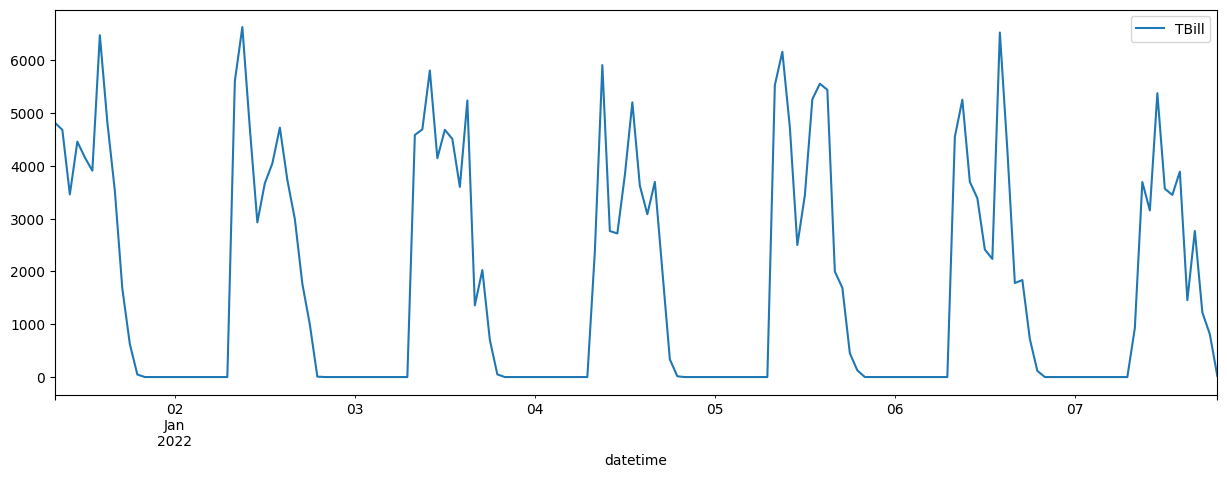

In [54]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [55]:
# SPLIT THE MAIN DATASET INTO TRAIN AND TEST DATASETS
# Determine the split point based on the desired ratio (80% train, 20% test)
split_index = int(split_ratio * len(ts))

# Split the data into training and testing datasets
df_train = ts.iloc[:split_index]
df_test = ts.iloc[split_index:]

In [56]:
# EXTRACT ONLY WHAT'S REQUIRED FROM THE DATASET
bill_train_unscaled = df_train['TBill'].to_numpy().reshape(-1, 1)
bill_test_unscaled = df_test['TBill'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
bill_train = scaler.fit_transform(bill_train_unscaled).flatten().tolist()
bill_test = scaler.transform(bill_test_unscaled).flatten().tolist()

In [57]:
# Sequence Data Preparation
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, bill_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, bill_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
print(x_train[:3])
print('-----------------')
print(y_train[:3])

tensor([[[1.3506],
         [1.2882],
         [0.7270]],

        [[1.2882],
         [0.7270],
         [1.1854]],

        [[0.7270],
         [1.1854],
         [1.0487]]])
-----------------
tensor([[1.1854],
        [1.0487],
        [0.9331]])


## LSTM model

In [59]:
# Simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
model = LSTMModel().to(device)


## Training the model

In [60]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.6983
Epoch 2/1000, Validation Loss: 0.6842
Epoch 3/1000, Validation Loss: 0.6689
Epoch 4/1000, Validation Loss: 0.6502
Epoch 5/1000, Validation Loss: 0.6275
Epoch 6/1000, Validation Loss: 0.5998
Epoch 7/1000, Validation Loss: 0.5697
Epoch 8/1000, Validation Loss: 0.5405
Epoch 9/1000, Validation Loss: 0.5236
Epoch 10/1000, Validation Loss: 0.5299
Epoch 11/1000, Validation Loss: 0.5476
Epoch 12/1000, Validation Loss: 0.5446
Epoch 13/1000, Validation Loss: 0.5212
Epoch 14/1000, Validation Loss: 0.5088
Epoch 15/1000, Validation Loss: 0.4983
Epoch 16/1000, Validation Loss: 0.4943
Epoch 17/1000, Validation Loss: 0.4884
Epoch 18/1000, Validation Loss: 0.4849
Epoch 19/1000, Validation Loss: 0.4808
Epoch 20/1000, Validation Loss: 0.4698
Epoch 21/1000, Validation Loss: 0.4597
Epoch 22/1000, Validation Loss: 0.4540
Epoch 23/1000, Validation Loss: 0.4510
Epoch 24/1000, Validation Loss: 0.4348
Epoch 25/1000, Validation Loss: 0.4188
Epoch 26/1000, Validation Loss: 0.

In [61]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 1250.9565


## Forecasting

<Axes: xlabel='datetime'>

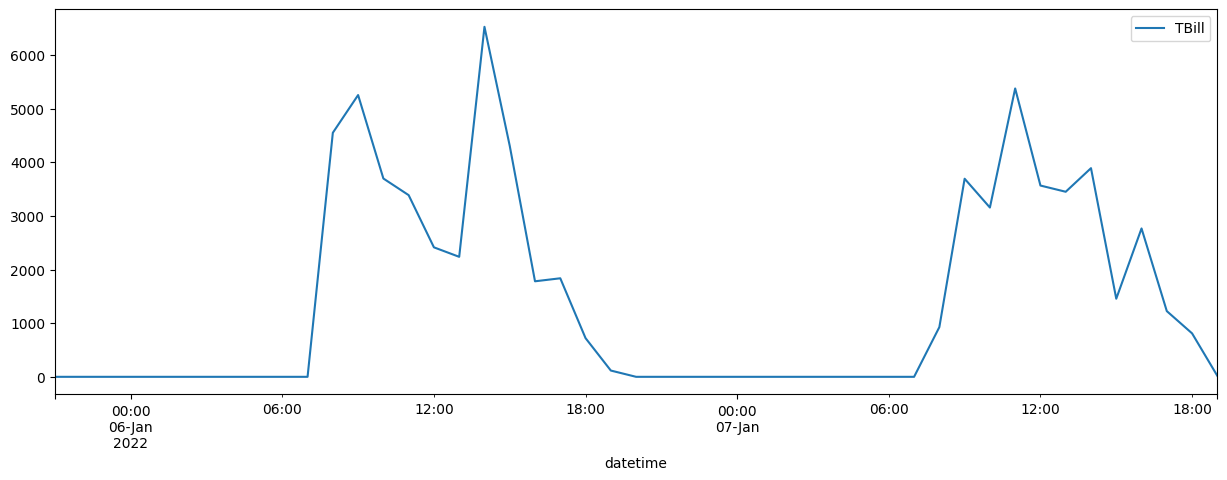

In [62]:
# plotting the aggregated series (ACTUAL TEST DATA)
df_test.plot(figsize=(15, 5))

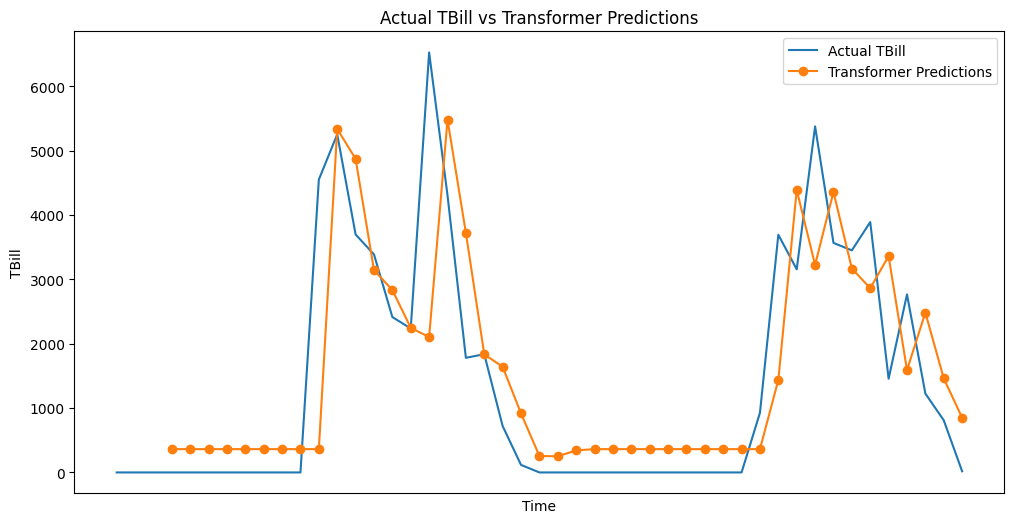

In [63]:
# PLOTTING COMPARISON
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the actual bill data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, scaler.inverse_transform(np.array(bill_test).reshape(-1, 1)), label='Actual TBill')

# Plotting the Transformer predictions
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_predictions.extend(outputs.squeeze().tolist())

# Convert predictions to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Plotting Transformer predictions
plt.plot(df_test.index[SEQUENCE_SIZE:], all_predictions, label='Transformer Predictions', marker='o')

# Formatting the plot
plt.title('Actual TBill vs Transformer Predictions')
plt.xlabel('Time')
plt.ylabel('TBill')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Display the plot
plt.show()
